In [1]:

!pip install diffusers transformers gradio scipy ftfy opencv-python "ipywidgets>=7,<8"
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-39ayk2fi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-39ayk2fi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import torch
import numpy as np
import cv2
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import matplotlib.pyplot as plt

# Download SAM model checkpoint (can also upload to colab if you have it)
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Load SAM
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda")
predictor = SamPredictor(sam)


--2025-06-26 04:05:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.123, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.2’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   274MB/s    in 1.3s    

2025-06-26 04:05:34 (274 MB/s) - ‘sam_vit_b_01ec64.pth.2’ saved [375042383/375042383]



In [4]:
def generate_sam_mask(input_image, input_point):
    image_np = np.array(input_image)
    predictor.set_image(image_np)

    input_point = np.array([input_point])
    input_label = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    return Image.fromarray((masks[0] * 255).astype(np.uint8))  # single-channel mask


In [8]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr

In [10]:
!rm -rf /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting



In [11]:
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
).to("cuda" if torch.cuda.is_available() else "cpu")

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
# Load image
image = Image.open("test5.png").convert("RGB")
image_np = np.array(image)
predictor.set_image(image_np)

# # Step 1: User draws bounding box
# import matplotlib.patches as patches

# bbox_coords = []

# def onselect(eclick, erelease):
#     global bbox_coords
#     x1, y1 = int(eclick.xdata), int(eclick.ydata)
#     x2, y2 = int(erelease.xdata), int(erelease.ydata)
#     bbox_coords = [x1, y1, x2, y2]
#     plt.close()

# fig, ax = plt.subplots()
# ax.imshow(image)
# from matplotlib.widgets import RectangleSelector
# selector = RectangleSelector(ax, onselect, useblit=True, button=[1])
# plt.title("Draw bounding box around object to remove")
# plt.show()



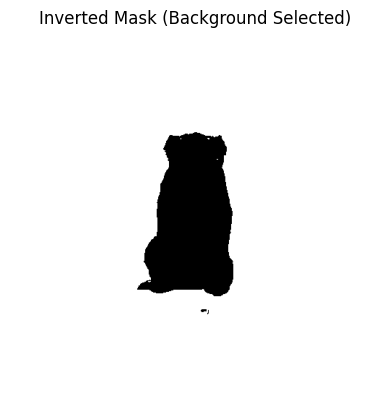

In [35]:
# Step 2: Generate mask using SAM
from PIL import Image, ImageOps
bbox_coords = [100, 150, 300, 400]  # Replace with your values manually

input_box = np.array([bbox_coords])
masks, scores, _ = predictor.predict(box=input_box, multimask_output=True)

# Pick best mask (highest score)
mask = masks[np.argmax(scores)]
mask_image = Image.fromarray((mask * 255).astype(np.uint8))

# # Show the selected mask
# plt.imshow(mask_image, cmap='gray')
# plt.title("Generated SAM Mask")
# plt.show()

background_mask_image = ImageOps.invert(mask_image)

# Show the background mask
plt.imshow(background_mask_image, cmap='gray')
plt.title("Inverted Mask (Background Selected)")
plt.axis("off")
plt.show()

In [28]:
# Step 3: Inpaint with SD
def inpaint_with_sd(image, mask, prompt, negative_prompt=None):
    image = image.resize((512, 512))
    mask = mask.resize((512, 512)).convert("L")
    mask = mask.point(lambda p: 255 if p > 10 else 0)

    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
    ).images[0]

    return result

In [38]:
num_variants = 5
images = []

for i in range(num_variants):
    generator = torch.Generator(device="cuda").manual_seed(i)  # different seed per run

    result = pipe(
        prompt="a scenic background with the Eiffel Tower, Paris skyline, blue sky",
        negative_prompt="blurry, distorted, low quality",
        image=image.convert("RGB").resize((512, 512)),
        mask_image=background_mask_image.convert("L").resize((512, 512)),
        generator=generator
    ).images[0]

    images.append(result)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

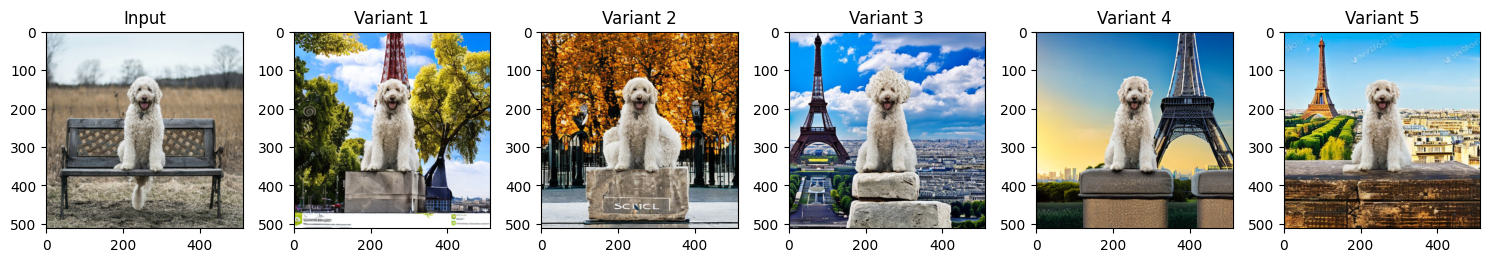

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1, num_variants + 1, 1); plt.imshow(image); plt.title("Input")

for i in range(num_variants):
    plt.subplot(1, num_variants + 1, i + 2)
    plt.imshow(images[i])
    plt.title(f"Variant {i+1}")

plt.tight_layout()
plt.show()
